# Exercise set 5: Partial Least squares and training and testing.

The main goals of this exercise are to perform Partial Least Squares (PLS) regression and use training and testing sets. Using training and testing sets allows us to assess the model's ability to generalize to unseen data and avoid overfitting. 

**Learning Objectives:**

After completing this exercise set, you will be able to:

- Create a PLS regression model.
- Create and use training and test sets.
- Assess your regression model by calculating root mean squared errors.

**To get the exercise approved, complete the following problems:**

* [5.1(a)](#5.1(a)), [5.1(b)](#5.1(b)), and [5.1(c)](#5.1(c)): To show that you can train a Partial Least Squares regression model and calculate RMSEC (Root Mean Squared Error of Calibration) and RMSEP (Root Mean Squared Error of Prediction).

**Note:**
Exercises [5.1(d)](#5.1(d)), [5.1(e)](#5.1(e)), [5.2(b)](#5.2(b)), [5.3(b)](#5.3(b)), [5.3(c)](#5.3(c)), [5.3(d)](#5.3(d)) involve programming of a complexity beyond what you are expected to handle independently, particularly under exam time pressure. Understanding the results and the underlying concepts are more important and to help you practice this (without focusing on the technical programming part), you can find partial solutions (without interpretation) in [appendix B](#B.-Partial-answers-to-some-of-the-exercises), specifically:

* [5.1(e)](#5.1(e)): You can use the figure in [appendix B.1](#B.1-Results-for-5.1(e)) to compare the performance of the model for the training and test sets. Make sure that you understand what the figure is showing.

* [5.3(b)](#5.3(b)): The X-scores and PLS X-rotations can be found in the figure in [appendix B.2](#B.2-Results-for-5.3(b)).

* [5.3(c)](#5.3(c)): The Y-scores and PLS Y-rotations can be found in the figure in [appendix B.3](#B.3-Results-for-5.3(c)).

* [5.3(d)](#5.3(d)): The PLS loadings for X and Y can be found in the figure in [appendix B.4](#B.4-Results-for-5.3(d)).

For [5.1(d)](#5.1(d)) and [5.2(b)](#5.2(b)), ensure you understand the process and purpose of cross-validation. One way to check your understanding is to explain it to a classmate.

## Exercise 5.1 Partial Least Squares with training and testing

[Windig and Stephenson](https://doi.org/10.1021/ac00046a015) measured near-infrared spectra
for 140 mixtures of the solvents methylene chloride, 2-butanol, methanol,
dichloropropane, and acetone. Here, we will predict the compositions of the mixtures from the spectra.
Each spectrum was sampled at 700 wavelengths
between 1100 and 2500 nm. The file
[`windig.csv`](windig.csv) contains the raw data:
Each row in this file
contains a spectrum (the columns starting with `wavelength.`) and the
corresponding concentrations (the columns starting with `conc.`).

**The goal of exercise 5.1 is to make a model for predicting the composition of a mixture from its spectrum.**

In [4]:
%reset -f

You can inspect the raw data by:

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
sns.set_theme(style="ticks", context="notebook", palette="colorblind")


data = pd.read_csv("windig.csv")
X = data.filter(like="wavelength", axis=1).values  # NIR spectra
Y = data.filter(like="conc", axis=1).values  # Concentrations
print(f"No. of spectra: {X.shape[0]}")
print(f"No. of wavelengths: {X.shape[1]}")
print(f"No of concentration samples: {Y.shape[0]}")
print(f"No of species in each sample: {Y.shape[1]}")

No. of spectra: 140
No. of wavelengths: 700
No of concentration samples: 140
No of species in each sample: 5


In [6]:
## Data structure: 
# wl1 wl2 ... wl700 c1 c2 ... c5      #spectra 1
# wl1 wl2 ... wl700 c1 c2 ... c5      #spectra 2
data.head() 

,wavelength.1,wavelength.2,wavelength.3,wavelength.4,wavelength.5,wavelength.6,wavelength.7,wavelength.8,wavelength.9,wavelength.10,...,wavelength.696,wavelength.697,wavelength.698,wavelength.699,wavelength.700,conc.methylene_chloride,conc.2-butanol,conc.methanol,conc.dichloropropane,conc.acetone
0,-0.022394,-0.022166,-0.021923,-0.021685,-0.021438,-0.021136,-0.020781,-0.020374,-0.019943,-0.019568,...,0.763176,0.763647,0.760546,0.756040,0.751364,10.05,47.42,10.00,10.02,22.52
1,-0.020301,-0.020301,-0.020280,-0.020225,-0.020149,-0.020062,-0.019940,-0.019778,-0.019584,-0.019294,...,1.119380,1.109189,1.098971,1.089740,1.081521,47.20,10.08,22.42,9.94,10.36
2,-0.025083,-0.025028,-0.024966,-0.024916,-0.024825,-0.024689,-0.024492,-0.024243,-0.023975,-0.023637,...,1.059119,1.052997,1.045820,1.038592,1.031878,34.93,10.02,22.46,22.61,9.99
3,-0.023544,-0.023471,-0.023394,-0.023279,-0.023124,-0.022921,-0.022658,-0.022352,-0.021997,-0.021560,...,0.829499,0.830703,0.825172,0.815957,0.804461,9.95,10.07,9.93,47.16,22.87
4,-0.020956,-0.020880,-0.020803,-0.020698,-0.020579,-0.020427,-0.020209,-0.019919,-0.019560,-0.019166,...,1.065883,1.062365,1.056156,1.048299,1.040324,22.46,10.12,22.46,22.43,22.51


And the individual spectra can be visualised with:

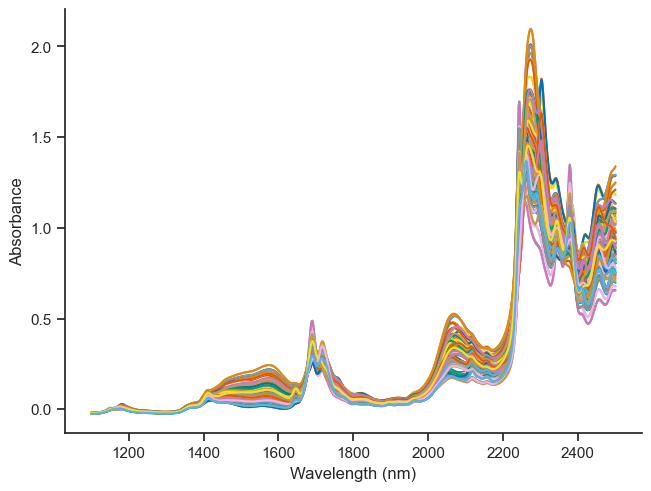

In [7]:
# To plot the spectra:
fig, ax = plt.subplots(constrained_layout=True)
wavelengths = np.linspace(1100, 2500, np.shape(X)[1])
for spectrum in X:
    ax.plot(wavelengths, spectrum)
ax.set(xlabel="Wavelength (nm)", ylabel="Absorbance")
sns.despine(fig=fig)

**Note:** The spectra have been processed so you can use them directly.

### 5.1(a)

To develop and assess your model, you will create and make use of a training and testing data set.

**Explain what the purposes of these two sets are and how they can be created.**

#### Your answer to question 5.1(a): What is the purpose of the training and testing data sets, and how are they created?

*Double click here*

The purpose is to have one data set for making the model and one for testing the model. The main point here is to test the model on data that it has not been trained on, to see if it can actually predict new, unseen data. By doing this, we can also see check if the model has been "over fitted", i.e., it predicts the training set with much higher precision than the test set. 

The are created by (randomly) splitting the original data ste into two smalelr dubsets. Typically, the training set comprises 2/3 of the original data, and the test set 1/3 of data. 

### 5.1(b)

**Split the raw data into a training set and a test set. Use 33% of the data for the test set. How many samples do you have in the training set and the test set?**

**Hint:** With scikit-learn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), splitting the data can be done with
```python
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.33,  # Use 33 % of the data (one-third) for the test set.
    shuffle=True,  # Randomly shuffle the data
)
```

In [8]:
# Your code here
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.33,  # Use 33 % of the data (one-third) for the test set.
    shuffle=True,    # Randomly shuffle the data
    random_state=2025, 
)

print(f"X_train: \t {np.shape(X_train)}")
print(f"Y_train: \t {np.shape(Y_train)}")
print(f"X_test \t\t {np.shape(X_test)}")
print(f"Y_test \t\t {np.shape(Y_test)}")

X_train: 	 (93, 700)
Y_train: 	 (93, 5)
X_test 		 (47, 700)
Y_test 		 (47, 5)


#### Your answer to question 5.1(b): How many samples do you have in the training set and the test set?
*Double click here*

I have 93 samples in the training set, and 47 samples in the test set. This totals to 93 + 47 = 140 samplaes, i.e., the total number of spectra --> OK. 

### 5.1(c)

**Task: Create a Partial Least Squares (PLS) regression model for predicting the concentrations from the spectra. Use 2 latent variables for the PLS model and evaluate your model by calculating the RMSEC (root mean squared error of calibration) and RMSEP (root mean squared error of prediction) for each of the five concentrations.**

**Hints:**

1.  **Create a PLS regression model:**
    ```python
    from sklearn.cross_decomposition import PLSRegression
    # Set up a PLS model:
    model = PLSRegression(
        n_components=2,  # Use two components (latent variables)
        scale=False,  # Do not scale X and Y (we will do this separately, if needed)
    )
    ```

2.  **Fit the model to the training data:**
    ```python
    model.fit(X_train, Y_train)  # Fit/make the model
    ```

3.  **Calculate the RMSEC (root mean squared error of calibration):**
    * When we use the training set to create our model, we are doing a *calibration*. If we calculate the RMSE (root mean squared error) based on the training set, we refer to this as the RMSEC. This quantifies the error we get in connection with making (calibrating) the model.
    ```python
    from sklearn.metrics import root_mean_squared_error

    y_hat_train = model.predict(X_train)
    rmsec = root_mean_squared_error(Y_train, y_hat_train)
    ```

4.  **Calculate the RMSEP (root mean squared error of prediction):**
    * When we use the test set to test our model, we are checking how well our model *predicts* "new" samples (that is, samples not used when making the model). If we calculate RMSE based on the test set, we refer to this as the RMSEP. This quantifies the error we can expect to make when using our model for predicting new samples.
    ```python
    y_hat_test = model.predict(X_test)
    rmsep = root_mean_squared_error(Y_test, y_hat_test)
    ```

In [9]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import root_mean_squared_error

In [10]:
# Your code here

# Create a PLS regression model 
# Set up a PLS model:
model = PLSRegression(
    n_components=2,  # Use two components (latent variables)
    scale=False,     # Do not scale X and Y, as this is done separetely 
)

# Fit the model to the training data: 
model.fit(X_train, Y_train)  # Fit/make the model

# Calculate the RMSEC (root mean squared error of calibration) 
#  When we use the training set to create our model, we are doing a *calibration*. 
#  If we calculate the RMSE (root mean squared error) based on the training set, 
#  we refer to this as the *RMSEC*. This quantifies the error we get in connection 
#  with making (calibrating) the model.
y_hat_train = model.predict(X_train)
rmsec = [root_mean_squared_error(Y_train[:,i], y_hat_train[:,i]) for i in range(5)] #rmsec for 5 compounds 
print(f"RMSEC: {rmsec} \n mean: {np.mean(rmsec):.3g}")

# Calculate the RMSEP (root mean squared error of prediction) 
#  When we use the test set to test our model, we are checking how well our model 
#  *predicts* "new" samples (that is, samples not used when making the model). 
#  If we calculate RMSE based on the test set, we refer to this as the *RMSEP*. This 
#  quantifies the error we can expect to make when using our model for predicting new samples.
y_hat_test = model.predict(X_test)
rmsep = [root_mean_squared_error(Y_test[:,i], y_hat_test[:,i]) for i in range(5)]
print(f"RMSEP: {rmsep} \n mean: {np.mean(rmsep):.3g}")

RMSEC: [5.801660093028027, 7.753231493937974, 2.0665687896152085, 11.320990076461234, 10.829561043896968] 
 mean: 7.55
RMSEP: [6.837585568468142, 8.479070846937327, 2.387592431160301, 11.310365331478435, 14.442154829717246] 
 mean: 8.69


In [11]:
# Comapre RMSEP with Y
print(f"Mean(Y):\t {np.mean(Y, axis=0)}")
rel_rmsep = rmsep / np.mean(Y, axis=0)
print(f"RMSEP/Mean(Y):\t {(100*rel_rmsep)} %")

Mean(Y):	 [19.91914286 20.13455714 19.95128571 19.99757143 19.99757143]
RMSEP/Mean(Y):	 [34.32670581 42.11203051 11.96711062 56.5586945  72.21954366] %


In [12]:
#Y_test[0,:]  #(5,1)  -> conc. of 5 comp. for 1st spectrum 
#Y_test[:,0]  #(47,1) -> conc. of 1st comp. for 47 spectra 

#### Your answer to question 5.1(c): What values did you get for RMSEC and RMSEP.
*Double click here*

See above print statements. The `RMSEP` are between 12 and 72 % of the mean cocnentration values, i.e., rather large. 

### 5.1(d)

**Task: Optimize the number of PLS components by performing cross-validation on a grid where you vary the number of components. Calculate RMSEC, RMSECV (root mean squared error of cross-validation), and RMSEP for your new model. Report the optimal number of components.**

**Hints:**

1. **Optimize the number of components by using cross-validation on a grid of possible parameters, for instance, by using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for scikit-learn:**
```python
from sklearn.model_selection import GridSearchCV

parameters = {"n_components": range(1, 11)}  # Test 1 through 10 components
# Set up a search over the parameter space:
grid_search = GridSearchCV(
    PLSRegression(scale=False),  # The base model
    parameters,  # The parameters we will consider,
    cv=5,  # The number of splits for the cross-validation
    scoring="neg_mean_squared_error",  # How we score how well the model is performing
    refit=True,  # Refit using the best-found parameters on the whole training set.
)
# Run the cross-validation
grid_search.fit(X_train, Y_train)
# Get the best number of components:
best_components = grid_search.best_params_["n_components"]
# Get the best-performing model:
best_model = grid_search.best_estimator_
# Get the results per parameter considered:
mean_score = grid_search.cv_results_["mean_test_score"]  # The mean score
error_score = grid_search.cv_results_[
    "std_test_score"
]  # The uncertainty in the score
# These two can be plotted as a function of the number of parameters considered;
# this can help us see the best parameters while considering the error.
```

2. **Recalculate RMSECV using the optimized model, for instance, by using [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) from scikit-learn:**
```python
from sklearn.model_selection import cross_val_score

cvscore = cross_val_score(
    model,  # Select the model we are going to score
    X_train,  # Give the X-training set
    Y_train,  # Give the y-training set
    scoring="neg_mean_squared_error",  # select scoring method
    cv=5,  # Number of splits to make
)
cvscore = np.sqrt(-cvscore)  # Account for the negative sign.
rmsecv = cvscore.mean()
rmsecv_std = np.std(cvscore)
print(f"\nRMSECV: {rmsecv} ± {rmsecv_std}")
```

**Note:** We use a *negative* mean squared error for the grid search and for calculating RMSECV. This is because the methods `cross_val_score` and `GridSearchCV` are often used in connection with optimization where we want to *maximize* something. If we *maximize the negative* of the mean squared error, we can *minimize the error*.

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [14]:
# Your code here

# Optimize the number of components by using cross-validation on a grid of possible 
#  PLS components by using `GridSearchCV` from scikit-learn  
parameters = {"n_components": range(1, 41)}  # Test 1 through 40 components
# Set up a search over the parameter space:
grid_search = GridSearchCV(
    PLSRegression(scale=False),  # The base model
    parameters,  # The parameters we will consider,
    cv=5,  # The number of splits for the cross-validation
    scoring="neg_mean_squared_error",  # Maximize -MSE to minimize the error 
    refit=True,  # Refit using the best-found parameters on the whole training set.
)
# Run the cross-validation
grid_search.fit(X_train, Y_train)

# Get the best number of components:
best_components = grid_search.best_params_["n_components"]
print(f"Best components: {best_components}")
# Get the best-performing model:
best_model = grid_search.best_estimator_
# Get the results per parameter considered:
mean_score  = grid_search.cv_results_["mean_test_score"]  # The mean score
error_score = grid_search.cv_results_["std_test_score"]   # The uncertainty in the score

# Recalculate RMSECV using the optimized model by using 
#  `cross_val_score` from scikit-learn 
cvscore = cross_val_score(
    model,  # Select the model we are going to score
    X_train,  # Give the X-training set
    Y_train,  # Give the y-training set
    scoring="neg_mean_squared_error",  # select scoring method
    cv=5,  # Number of splits to make
)
cvscore = np.sqrt(-cvscore)  # Account for the negative sign.
rmsecv = cvscore.mean()
rmsecv_std = np.std(cvscore)
print(f"\nRMSECV: {rmsecv} ± {rmsecv_std}")

Best components: 32

RMSECV: 8.594906917311627 ± 0.747827070763257


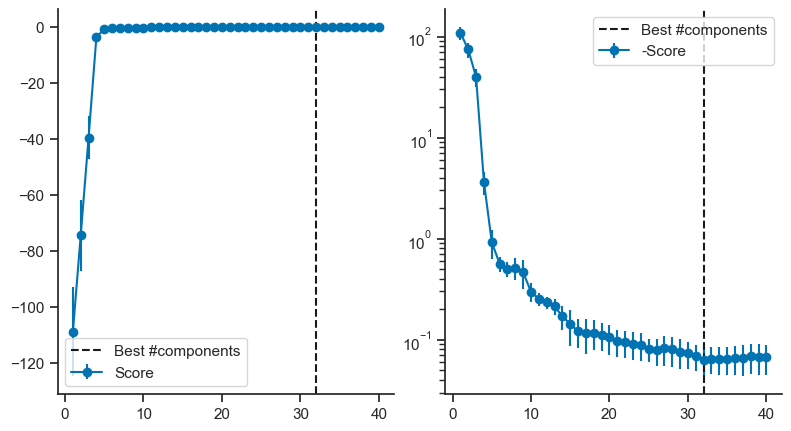

In [15]:
fig,(ax0, ax1) = plt.subplots(ncols=2, 
                              figsize=(7.8, 4.2), 
                              layout='constrained')

cutoff = 40
n_components = list(parameters['n_components'])[0:cutoff]
mean_score_plot = mean_score[0:cutoff]
error_score_plot = error_score[0:cutoff]

# Plot with linear y-axis 
ax0.errorbar(n_components, mean_score_plot, yerr=error_score_plot, marker='o', label='Score')
ax0.axvline(best_components, c='k', ls='--', label='Best #components')
ax0.legend()

# Plot with logarithmic y-axis 
ax1.errorbar(n_components, -mean_score_plot, yerr=error_score_plot, marker='o', label='-Score')
ax1.axvline(best_components, c='k', ls='--', label='Best #components')
ax1.legend()
ax1.set_yscale('log')

sns.despine(fig=fig)

In [16]:
# Fit the optimized model to the training data: 
best_model.fit(X_train, Y_train)  # Fit/make the model

# Calculate the RMSEC (root mean squared error of calibration) 
y_hat_train_best = best_model.predict(X_train)
rmsec_best = [root_mean_squared_error(Y_train[:,i], y_hat_train_best[:,i]) for i in range(5)] #rmsec for 5 compounds 
print(f"RMSEC: {rmsec_best} \n mean: {np.mean(rmsec_best):.3g}")

# Calculate the RMSEP (root mean squared error of prediction) 
y_hat_test_best = best_model.predict(X_test)
rmsep_best = [root_mean_squared_error(Y_test[:,i], y_hat_test_best[:,i]) for i in range(5)]
print(f"RMSEP: {rmsep_best} \n mean: {np.mean(rmsep_best):.3g}")

RMSEC: [0.08020300024910278, 0.06755639660464066, 0.10463742072417478, 0.09711301722207495, 0.0878072014170264] 
 mean: 0.0875
RMSEP: [0.24807537315318434, 0.21939020213522697, 0.2647575265615785, 0.3232350560207416, 0.28759752116415666] 
 mean: 0.269


In [17]:
# Comapre RMSEP with Y
print(f"Mean(Y):\t {np.mean(Y, axis=0)}")
rel_rmsep_best = rmsep_best / np.mean(Y, axis=0)
print(f"RMSEP/Mean(Y):\t {(100*rel_rmsep_best)} %")

Mean(Y):	 [19.91914286 20.13455714 19.95128571 19.99757143 19.99757143]
RMSEP/Mean(Y):	 [1.24541189 1.0896202  1.32701987 1.61637155 1.43816224] %


#### Your answer to question 5.1(d): What is the optimal number of components?
*Double click here*

Strictly speaking, the optimal number of components in the range [1, 40] is 32. However, we also see that the score gain for increasing number of components above ~5-7 is very small. Thus, one could choose e.g. 6. 

### 5.1(e)

**Task: Show the results for the training data and the testing data graphically by plotting the predicted vs. the observed values for all 5 chemical components for the optimized model. Include RMSEC, R² for the training set, RMSEP and R² for the test set as labels in your figure (calculate these for each component separately). Further, report the metrics you calculated in a table.**

**Hint:** The R² can be calculated using:
```python
from sklearn.metrics import r2_score

component_number = 1  # To select a column (one component) from Y:
r_squared_train = r2_score(Y_train[:,component_number], y_predicted_train[:,component_number])
r_squared_test = r2_score(Y_test[:,component_number], y_predicted_test[:,component_number])
```

In [18]:
from sklearn.metrics import r2_score

In [19]:
# Make new model with n=6 components 
model_opt = PLSRegression(n_components=6, scale=False) 
model_opt.fit(X_train, Y_train)  # Fit/make the model

y_hat_train_opt = model_opt.predict(X_train)
rmsec_opt = [root_mean_squared_error(Y_train[:,i], y_hat_train_opt[:,i]) for i in range(5)] #rmsec for 5 compounds 

y_hat_test_opt = model_opt.predict(X_test)
rmsep_opt = [root_mean_squared_error(Y_test[:,i], y_hat_test_opt[:,i]) for i in range(5)]

In [20]:
# Your code here
r_squared_train_opt = [r2_score(Y_train[:,i], y_hat_train_opt[:,i]) for i in range(5)]
r_squared_train_opt_print = [f"{x:.3g}" for x in r_squared_train_opt]
print(f"R^2 train: \t {r_squared_train_opt_print}")

r_squared_test_opt  = [r2_score(Y_test[:,i], y_hat_test_opt[:,i]) for i in range(5)]
r_squared_test_opt_print = [f"{x:.3g}" for x in r_squared_test_opt]
print(f"R^2 test: \t {r_squared_test_opt_print}")

R^2 train: 	 ['0.996', '0.997', '0.997', '0.996', '0.999']
R^2 test: 	 ['0.994', '0.998', '0.995', '0.992', '0.998']


In [21]:
rmsec_opt_print = [f"{x:.3g}" for x in rmsec_opt]
rmsep_opt_print = [f"{x:.3g}" for x in rmsep_opt]
print(f"RMSEC: {rmsec_opt_print}")
print(f"RMSEP: {rmsep_opt_print}")

RMSEC: ['0.775', '0.565', '0.687', '0.829', '0.416']
RMSEP: ['0.913', '0.667', '0.872', '0.955', '0.541']


In [110]:
def add_yx(y, y_hat, ax, legend=False): 
    min_val = min(min(y), min(y_hat))
    max_val = max(max(y), max(y_hat))
    yx = ax.plot(
        [min_val, max_val], [min_val, max_val], 
        c="k", ls='--', lw=1, label=None if not legend else 'Perfect fit', 
        zorder=0, 
    )
    return yx 

Text(0.02, 0.5, '$\\hat{y}$ predicted')

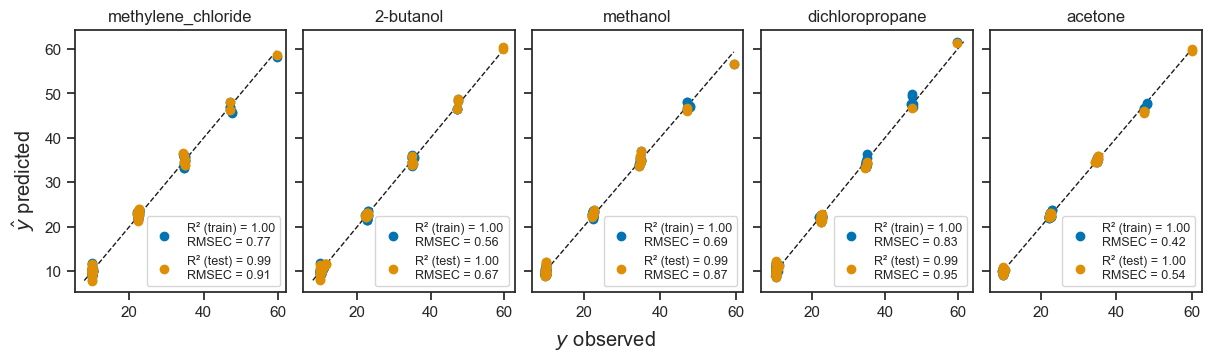

In [111]:
fig, axs = plt.subplots(ncols=5, nrows=1, 
                        layout='constrained', 
                        figsize=(12, 3.5), 
                        sharex='col', sharey='row')

for i, ax in enumerate(axs): 
    # plot train 
    txt_train = f"R² (train) = {r_squared_train_opt[i]:.2f}\nRMSEC = {rmsec_opt[i]:.2f}"
    ax.scatter(Y_train[:,i], y_hat_train_opt[:,i], label=txt_train, c='C0') 
    
    #plot test 
    txt_test = f"R² (test) = {r_squared_test_opt[i]:.2f}\nRMSEC = {rmsep_opt[i]:.2f}"
    ax.scatter(Y_test[:,i], y_hat_test_opt[:,i], label=txt_test, c='C1') 

    # Set title, add y=x, make legend 
    ax.set_title(data.columns[-5:][i][5:], loc='center')
    y_data = np.concatenate((Y_train[:,i], Y_test[:,i]))
    y_pred = np.concatenate((y_hat_train_opt[:,i], y_hat_test_opt[:,i]))
    yx = add_yx(y_data, y_pred, ax, legend=False)
    ax.legend(loc='lower right', fontsize=9)

fig.supxlabel(r'$y$ observed')
fig.supylabel(r'$\hat{y}$ predicted')

In [24]:
# Check if grouping is resonable 
for key in data.columns[-5:]: 
    print(key)
    print(np.unique([round(x) for x in data.loc[:,key].sort_values()]) ) #round to nearest int 
    print('\n')

conc.methylene_chloride
[10 22 23 34 35 47 48 60]


conc.2-butanol
[10 11 12 22 23 35 36 47 48 60]


conc.methanol
[10 22 23 35 47 48 59]


conc.dichloropropane
[10 11 22 23 35 47 48 60]


conc.acetone
[10 11 22 23 34 35 47 48 60]




#### Your answer to question 5.1(e): Report the metrics you found:
*Double click here*

| Component                        | RMSEC | RMSEP | R² (train) | R² (test) |
|----------------------------------|-------|-------|------------|-----------|
| methylene chloride (component 1) |0.775|0.913|0.996|0.999|
| 2-butanol (component 2)          |0.565|0.913|0.997|0.999|
| methanol (component 3)           |0.687|0.872|0.997|0.999|
| dichloropropane (component 4)    |0.829|0.955|0.996|0.992|
| acetone (component 5)            |0.829|0.541|0.999|0.998|

## Exercise 5.2 Use of cross-validation when we have few samples

It is not always feasible to do the split into training and test sets when we have few samples. Another option then is to use something called **Leave-one-out cross-validation** (LOOCV). LOOCV involves training the model on all but one data point and using the remaining point for testing, repeating this process for each data point. We will use that method in this exercise

We will use the data of [Forbes](https://doi.org/10.1017/S0080456800032075) who investigated the
relationship between the boiling point of water and the atmospheric pressure, and collected data in the Alps and Scotland. Forbes' goal was to estimate altitudes from the boiling point alone.

### 5.2(a)

**Task: Load the data from Forbes (data file [forbes.csv](forbes.csv)), plot it, and create a linear regression model
that predicts the atmospheric pressure from the temperature. Report the R² and [root mean
squared error (RMSE)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html) for your model.**

,Temperature (F),Pressure (inches Hg)
0,194.5,20.79
1,194.3,20.79
2,197.9,22.40
3,198.4,22.67
4,199.4,23.15


<Axes: xlabel='Temperature (F)', ylabel='Pressure (inches Hg)'>

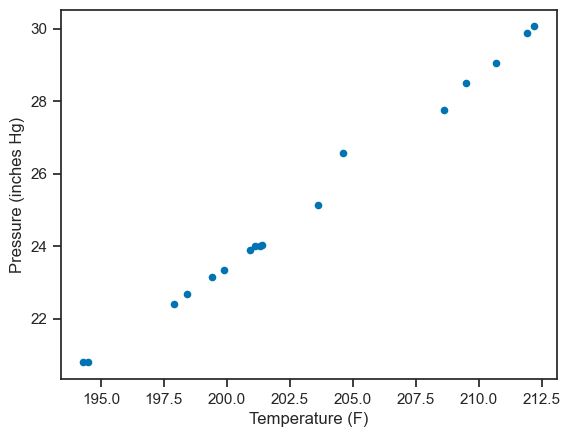

In [25]:
# Your code here
data52 = pd.read_csv('forbes.csv') 
display(data52.head())
data52.plot(x='Temperature (F)', y='Pressure (inches Hg)', kind='scatter')

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

C:\Users\haavarug\AppData\Local\Temp\ipykernel_12644\3706951483.py:31: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  X_eval = np.row_stack([min(X_forbes), max(X_forbes)])


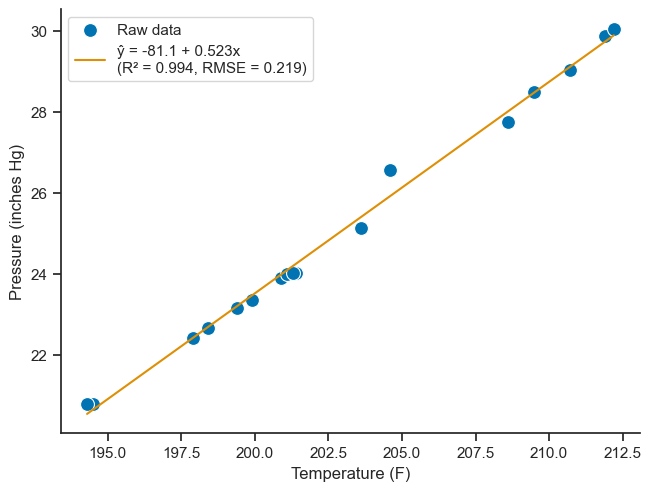

In [27]:
## Prepare data 
X_forbes = data52['Temperature (F)'].to_numpy().reshape(-1,1)
y_forbes = data52['Pressure (inches Hg)'].to_numpy()


## Do linear regression 
# Make model 
model_forbes = LinearRegression(fit_intercept=True)

# Fit model 
model_forbes.fit(X_forbes, y_forbes)

# Use model to predict 
y_hat_forbes = model_forbes.predict(X_forbes)

# Calculate R2 and RMSE 
r2_forbes = r2_score(y_forbes, y_hat_forbes)
rmse_forbes = root_mean_squared_error(y_forbes, y_hat_forbes)


## Plot data with model 
fig, ax = plt.subplots(constrained_layout=True)
sns.scatterplot(
    data=data52,
    x="Temperature (F)",
    y="Pressure (inches Hg)",
    label="Raw data",
    s=100,
)

X_eval = np.row_stack([min(X_forbes), max(X_forbes)])
y_eval = model_forbes.predict(X_eval)

text = f"ŷ = {model_forbes.intercept_:.3g} + {model_forbes.coef_[0]:.3g}x"
text = f"{text}\n(R² = {r2_forbes:.3g}, RMSE = {rmse_forbes:.3g})"

ax.plot([], [])  # To cycle colors
ax.plot(
    X_eval.flatten(),
    y_eval.flatten(),
    label=text,
)
ax.legend()
sns.despine(fig=fig)

#### Your answer to question 5.2(a): What value did you get for R² and the RMSE?
*Double click here*

### 5.2(b)

**Task: Estimate the error you can expect to make if you use your model for predicting the pressure.
Do this by LOOCV and calculate the root mean squared error of cross-validation (RMSECV)**

**Note:** LOOCV is a special case of **training** and **testing**, and you can find a short description of it
in [appendix A](#A.-Leave-one-out-cross-validation) with example code for running LOOCV. The code example for LOOCV is concise, so make sure you understand what goes on here (that is, what LOOCV is doing). If you are working with someone, try explaining testing/training and how LOOCV works to them.

In [50]:
from sklearn.model_selection import LeaveOneOut

In [54]:
# Method 1 

# Perform Leave-One-Out
loo = LeaveOneOut()
n_splits = loo.get_n_splits(X_forbes)
error = np.zeros(n_splits)

for i, (train_idx, test_idx) in enumerate(loo.split(X_forbes)): 
    # Index X and y -> train and test data sets 
    x_train, x_test = X_forbes[train_idx], X_forbes[test_idx] 
    y_train, y_test = y_forbes[train_idx], y_forbes[test_idx] #1D, the left out data point y_i

    # Make model, fit model, use model to predict 
    model = LinearRegression(fit_intercept=True)
    model.fit(x_train, y_train)
    y_hat = model.predict(x_test)

    # Calculate error between predicted and measured y_i 
    error[i] = ((y_test - y_hat)**2).item() #convert from 1Darray [x] to scalar x in order to array[i] = x

# Calculate root-mean-squared-error of cross-validation 
rmsecv_forbes_1 = np.sqrt(np.mean(error))
print(f"RMSECV = {rmsecv_forbes_1}")

RMSECV = 0.24235598486501164


In [53]:
from sklearn.model_selection import LeaveOneOut, cross_val_score

In [55]:
# Method 2:
model = LinearRegression(fit_intercept=True)
scores = cross_val_score(
    model,
    X_forbes,
    y_forbes,
    scoring="neg_mean_squared_error",
    cv=LeaveOneOut(),
)
rmsecv_forbes_2 = np.sqrt(np.mean(-scores))
print(f"RMSECV = {rmsecv_forbes_2}")

RMSECV = 0.24235598486501164


C:\Users\haavarug\AppData\Local\Temp\ipykernel_12644\4005290920.py:11: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  X_eval = np.row_stack([min(X_forbes), max(X_forbes)])


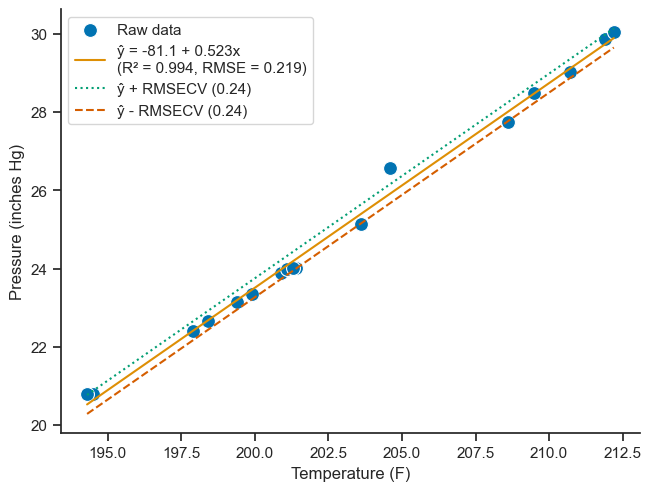

In [56]:
fig, ax = plt.subplots(constrained_layout=True)

sns.scatterplot(
    data=data52,
    x="Temperature (F)",
    y="Pressure (inches Hg)",
    label="Raw data",
    s=100,
)

X_eval = np.row_stack([min(X_forbes), max(X_forbes)])
y_eval = model_forbes.predict(X_eval)

upper = y_eval + rmsecv_forbes_2
lower = y_eval - rmsecv_forbes_2

text = f"ŷ = {model_forbes.intercept_:.3g} + {model_forbes.coef_[0]:.3g}x"
text = f"{text}\n(R² = {r2_forbes:.3g}, RMSE = {rmse_forbes:.3g})"

ax.plot([], [])  # To cycle colors
ax.plot(
    X_eval.flatten(),
    y_eval.flatten(),
    label=text,
)

ax.plot(X_eval.flatten(), upper, label=f"ŷ + RMSECV ({rmsecv_forbes_2:.2g})", ls=":")
ax.plot(X_eval.flatten(), lower, label=f"ŷ - RMSECV ({rmsecv_forbes_2:.2g})", ls="--")

ax.legend()
sns.despine(fig=fig)

#### Your answer to question 5.2(b): What value did you get for RMSECV?
*Double click here*

## Exercise 5.3 Partial Least Squares and interpretation of scores and loadings

The file [elements.csv](elements.csv) contains information about the elements of the periodic table. This dataset includes various physical and chemical properties, allowing us to explore the underlying relationships between these elements. The columns in the file are as follows:


| **Column**                      | **Description**                                         | **Unit** |
|:--------------------------------|:--------------------------------------------------------|:---------|
| name                            | The name of the element                                 |          |
| symbol                          | The symbol for the element (e.g. H, He, etc.)           |          |
| atomic_radius                   | Atomic radius                                           | Å        |
| atomic_weight                   | Atomic weight                                           | u        |
| covalent_radius                 | Covalent radius                                         | pm       |
| density                         | Density at 295 K                                        | g/cm³    |
| dipole_polarizability           | Dipole polarizability                                   | bohr³    |
| electrons                       | The number of electrons in the element                  |          |
| mass_number                     | Mass number of the most abundant isotope                |          |
| neutrons                        | The number of neutrons in the element                   |          |
| protons                         | The number of protons in the element                    |          |
| zeff                            | Effective nuclear charge                                |          |
| vdw_radius                      | Van der Waals radius                                    | pm       |
| first_ionization                | First ionization energy                                 | eV       |
| electronegativity allred-rochow | Allred and Rochow’s scale of electronegativity          | e²/pm²   |
| electronegativity gordy         | Gordy’s scale of electronegativity                      | e/pm     | 
| atomic_radius_wikipedia         | Atomic radius from [Wikipedia](https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page)) | pm |

### 5.3(a)

**Task: Create a PLS regression model for predicting `first_ionization`, `density`, `protons`, and `atomic_radius` from the other variables.**

**Notes:**:

1. Remove the non-numeric columns like 'name' and 'symbol' before creating the PLS model.

2. Use two components for the PLS regression model. Do not do a split into a training and test set in this exercise (this is not so crucial here since we will focus on interpreting scores and loadings).

3. Consider if you should normalize (scale) the data using a [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) before performing the PLS.

In [112]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import scale
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, root_mean_squared_error

In [113]:
# Your code here
data53 = pd.read_csv('elements.csv')
data53.head()

,name,symbol,atomic_radius,atomic_weight,covalent_radius,density,dipole_polarizability,electrons,mass_number,neutrons,protons,vdw_radius,first_ionization,electronegativity allred-rochow,electronegativity gordy,zeff,atomic_radius_wikipedia
0,Hydrogen,H,154.0,1.008000,32.0,0.000082,4.50711,1,1,0,1,110.0,13.598435,0.000977,0.031250,1.00,53.0
1,Helium,He,134.0,4.002602,46.0,0.000164,1.38375,2,4,2,2,140.0,24.587389,0.000803,0.036957,1.70,31.0
2,Lithium,Li,220.0,6.940000,133.0,0.534000,164.11250,3,7,4,3,182.0,5.391715,0.000073,0.009774,1.30,167.0
3,Beryllium,Be,219.0,9.012183,102.0,1.850000,37.74000,4,9,5,4,153.0,9.322699,0.000187,0.019118,1.95,112.0
4,Boron,B,205.0,10.810000,85.0,2.340000,20.50000,5,11,6,5,192.0,8.298019,0.000360,0.030588,2.60,87.0


In [ ]:
# remove non-numeric columns 
non_numeric_columns = data53.columns[~((data53.dtypes == 'float64') | (data53.dtypes == 'int64'))]
elements = data53.drop(non_numeric_columns.values, axis=1)

# make X and Y arrays 
y_columns = ['first_ionization', 'density', 'protons', 'atomic_radius']
X = elements.drop(y_columns, axis=1).to_numpy()
Y = elements.loc[:,y_columns].to_numpy()

# scale data 
X_scaled = scale(X)
Y_scaled = scale(Y)
print(f"shape(X):\t {np.shape(X_scaled)}")
print(f"shape(Y):\t {np.shape(Y_scaled)}")

shape(X):	 (85, 11)
shape(Y):	 (85, 4)


In [115]:
# Create PLS regression model and fit to data 
model = PLSRegression(n_components=2, scale=False)
model.fit(X_scaled, Y_scaled)

# Make predictions 
y_hat = model.predict(X_scaled)

# Evaluate the model 
rmsep = [root_mean_squared_error(Y_scaled[:,i], y_hat[:,i]) for i in range(4)]
print(f'RMSE: {rmsep}')
R2_score = [r2_score(Y_scaled[:,i], y_hat[:,i]) for i in range(4)]
print(f'R^2: {R2_score}')

RMSE: [0.5482831673403563, 0.681887362722004, 0.07143606158977286, 0.48767738497731056]
R^2: [0.6993855684112269, 0.5350296245600303, 0.9948968891045422, 0.762170768181692]


In [126]:
def add_yx(y_obs, y_hat, ax, legend=False): 
    min_val = min(min(y_obs), min(y_hat))
    max_val = max(max(y_obs), max(y_hat))
    yx = ax.plot(
        [min_val, max_val], [min_val, max_val], 
        c="k", ls='--', lw=1, label=None if not legend else 'Perfect fit', zorder=1, 
    )
    return yx 

C:\Users\haavarug\AppData\Local\Temp\ipykernel_12644\655423791.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


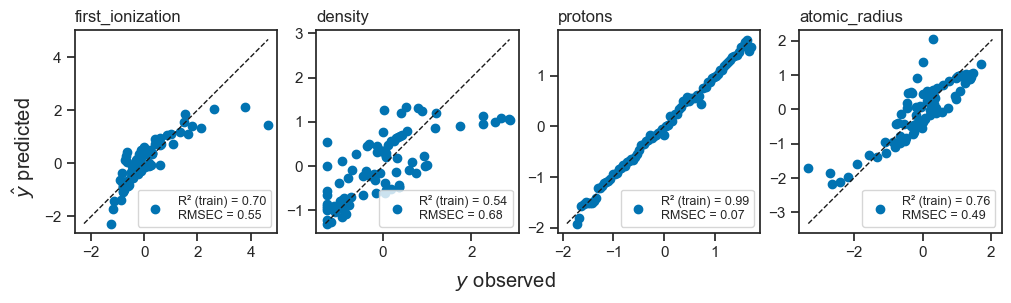

In [134]:
fig, axs = plt.subplots(ncols=4, layout='constrained', figsize=(10, 3.0))

for i, ax in enumerate(axs.flat): 
    txt = f"R² (train) = {R2_score[i]:.2f}\nRMSEC = {rmsep[i]:.2f}"
    ax.scatter(Y_scaled[:,i], y_hat[:,i], label=txt)

    # Set title, add y=x, make legend 
    ax.set_title(y_columns[i], loc='left')
    yx = add_yx(Y_scaled[:,i], y_hat[:,i], ax, legend=False)
    ax.legend(loc='lower right', fontsize=9)
    ax.set_aspect('equal')

fig.supxlabel(r'$y$ observed')
fig.supylabel(r'$\hat{y}$ predicted')

fig.show()

### 5.3(b)

**Task: Inspect the scores and rotations for X by creating 2D scatter plots. Are there any trends/groupings or outliers in the scores? What of the original X-variables can, if groups/trends are present, be used to interpret these trends?**

**Hints:**

1. Assuming that `pls` is the fitted object containing the PLS model, and `X` is our raw data, we can get the scores and rotations by:
```python
x_scores = pls.transform(X)
x_rotations = pls.x_rotations_
```

2. For the scatter plots, you have two options. To plot the scores and rotations for the two PLS components in two different plots, or in the same plot (as a biplot). The biplot can sometimes help interpretation, but can be crowded if there are many samples and features.


**Notes:**

1. We use the rotations here instead of the loadings (or weights). This is because the X-rotations apply directly to the X data to create the scores. Thus, the rotations tell use more directly the relation between the original variables and the calculated scores.

In [151]:
# add period to extended data frame 
from mendeleev import element 

data53_etx = data53.copy()
elem_period = [element(symbol).period for symbol in data53.loc[:,'symbol'] ]
data53_etx.insert(loc=2, column='period', value=elem_period)

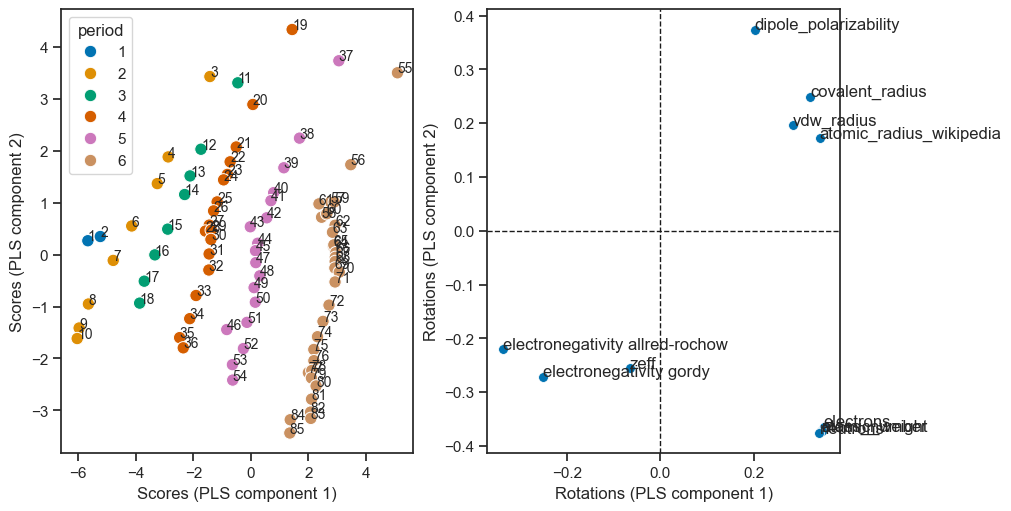

In [180]:
# Your code here
x_scores = model.transform(X_scaled)
x_rotations = model.x_rotations_

fig, (axS, axR) = plt.subplots(ncols=2, layout='constrained', figsize=(10,5)) 

# Plot scores 
sns.scatterplot(data53_etx, x=x_scores[:,0], y=x_scores[:,1], ax=axS, 
                s=80, hue='period', palette="colorblind") 
axS.set(
    xlabel=f"Scores (PLS component {1})",
    ylabel=f"Scores (PLS component {2})",
    )
for i, txt in enumerate(data53_etx["symbol"]):
    axS.text(
        x_scores[i, 0],
        x_scores[i, 1],
        f"{i+1}", #({txt})",
        fontsize="small",
    )


# Plot rotations 
sns.scatterplot(x=x_rotations[:,0], y=x_rotations[:,1], ax=axR, 
                s=50) 
axR.set(
    xlabel=f"Rotations (PLS component {1})",
    ylabel=f"Rotations (PLS component {2})",
    )
axR.axvline(c='k', lw=1, ls='--')
axR.axhline(c='k', lw=1, ls='--')
for i, xi in enumerate(elements.drop(y_columns, axis=1)):
    axR.text(x_rotations[i,0], x_rotations[i,1], xi, fontsize="medium")

#### Your answer to question 5.3(b): Are there any trends/groupings or outliers in the scores and what variables can be used to interpret them?

*Double click here*

### 5.3(c)

**Task: Inspect the scores and rotations for Y by creating 2D scatter plots. Are there any trends/groupings or outliers in the scores? What of the original Y-variables can, if groups/trends are present, be used to interpret these trends?**

**Hints:**

1. Assuming that `pls` is the fitted object containing the PLS model, and `X` and `Y` are our raw data, we can get the scores and rotations by:
```python
x_scores, y_scores = pls.transform(X, y=Y)
y_rotations = pls.y_rotations_
```

2. For the scatter plots, you have two options. To plot the scores and rotations for the two PLS components in two different plots, or in the same plot (as a biplot). The biplot can sometimes help interpretation, but can be crowded if there are many samples and features.


**Notes:**

1. We use the rotations here instead of the loadings (or weights). This is because the Y-rotations apply directly to the Y data to create the scores. Thus, the rotations tell use more directly the relation between the original variables and the calculated scores.

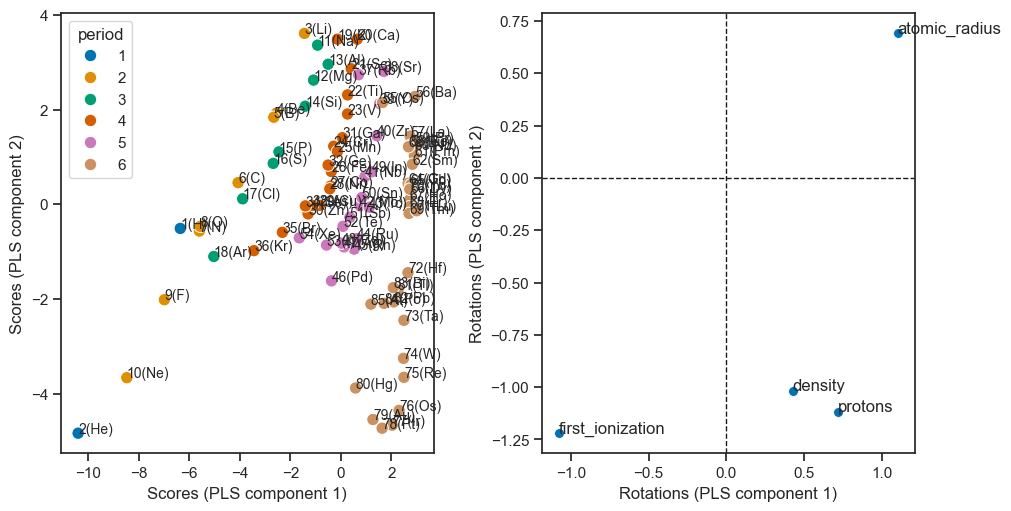

In [181]:
# Your code here

# Your code here
x_scores, y_scores = model.transform(X_scaled, y=Y_scaled)
y_rotations = model.y_rotations_

fig, (axS, axR) = plt.subplots(ncols=2, layout='constrained', figsize=(10,5)) 

# Plot scores 
sns.scatterplot(data53_etx, x=y_scores[:,0], y=y_scores[:,1], ax=axS, 
                s=80, hue='period', palette="colorblind") 
axS.set(
    xlabel=f"Scores (PLS component {1})",
    ylabel=f"Scores (PLS component {2})",
    )
for i, txt in enumerate(data53_etx["symbol"]):
    axS.text(
        y_scores[i, 0],
        y_scores[i, 1],
        f"{i+1}({txt})",
        fontsize="small",
    )


# Plot rotations 
sns.scatterplot(x=y_rotations[:,0], y=y_rotations[:,1], ax=axR, 
                s=50) 
axR.set(
    xlabel=f"Rotations (PLS component {1})",
    ylabel=f"Rotations (PLS component {2})",
    )
axR.axvline(c='k', lw=1, ls='--')
axR.axhline(c='k', lw=1, ls='--')
for i, xi in enumerate(elements.loc[:,y_columns]):
    axR.text(y_rotations[i,0], y_rotations[i,1], xi, fontsize="medium")

#### Your answer to question 5.3(c): Are there any trends/groupings or outliers in the scores and what variables can be used to interpret them?

*Double click here*

### 5.3(d)

**Task: Inspect the X-rotations and Y-loadings together. Which of the X-variables could be important for predicting the different Y-variables (answer this by exploring the correlations between the X-variables and the Y-variables).**

**Hints:** 

1. Assuming that `pls` is the fitted object containing the PLS model, we can get the scores for Y by:
```python
y_loadings = pls.y_loadings_
```

**Notes:**

1. We use the X-rotations ($R$) and Y-loadings ($Q$) because they help us understand the relationships between the X-variables and the Y-variables in the PLS model. The PLS model $Y = XB = XRQ^T$ shows that the regression coefficients ($B$) can be decomposed into the product of $R$ and $Q^T$. Therefore, plotting $R$ and $Q$ together helps us investigate correlations captured by the PLS model.

In [ ]:
# Your code here

#### Your answer to question 5.3(d): What X-variables seem important for predicting Y and what variables are correlated?
*Double click here*

# Appendix

## A. Leave-one-out cross-validation

In Leave-one-out cross-validation (LOOCV), we first pick one sample,
measurement number $j$, and we fit the model using the $n-1$ other points
(all points except $j$). After the fitting, we check how well the model can predict
measurement $j$ by calculating the difference between the
measured ($y_j$) and predicted ($\tilde{y}_j$) value. This difference, $r_j = y_{j} - \tilde{y}_j$, is
called the predicted residual, and it tells us the error we just made.

There is nothing special about picking point $j$, and we can try all possibilities
of leaving one point out, fitting the model using the remaining $n-1$
measurements, and predicting the value we left out.
After doing this for all possibilities, we have fitted the model
$n$ times and calculated $n$ predicted residuals. The mean squared error (obtained from the squared
residuals), $\mathrm{MSE}_{\mathrm{CV}}$, can then be used
to estimate the error in the model,

\begin{equation}
\mathrm{MSE}_{\mathrm{CV}} = \frac{1}{n} \sum_{i=1}^{n} r_i^2 =  \frac{1}{n} \sum_{i=1}^{n} (y_i - \tilde{y}_i)^2,
\end{equation}

where $y_i$ is the measured $y$ in experiment $i$, and $\tilde{y}_i$ is the
predicted $y$, using a model which was fitted using all points *except* $y_i$.

For a polynomial fitting, there is an alternative to refitting the model $n$ times. In fact,
we can show that for polynomial fitting, the mean squared error can
be obtained by,

\begin{equation}
\mathrm{MSE}_{\mathrm{CV}} = \frac{1}{n}\sum_{i=1}^{n} (y_i - \tilde{y}_i)^2 =
\frac{1}{n}\sum_{i=1}^{m} \left(\frac{y_i - \hat{y}_i}{1 - h_{ii}} \right)^2,
\end{equation}

where the $\hat{y}_i$'s are predicted values using the
model fitted with *all data points*,
and $h_{ii}$ is the $i$'th diagonal element of the
$\mathbf{H}$ matrix (the projection matrix,
see Eq.(4.49) on page 49 in our textbook),

\begin{equation}
\mathbf{H} =
\mathbf{X} 
\left( 
  \mathbf{X}^\mathrm{T} \mathbf{X}
\right)^{-1}
\mathbf{X}^\mathrm{T} = \mathbf{X} \mathbf{X}^+,
\end{equation}

Note the difference between $\hat{y}_i$ and $\tilde{y}_i$, and the
fact that we  do not have to do the
refitting(!) to obtain the $\mathrm{MSE}_{\mathrm{CV}}$.

When you calculate $\mathrm{MSE}_{\mathrm{CV}}$, use one of the two approaches above or both
if you want to see if they give the same answer.

In [ ]:
# The examples below assume that the matrix X is called X_temp
# and that y is stored in the variable pressure.

# Example 1 of LOOCV:
from sklearn.linear_model import LinearRegression

# scikit-learn has a method to pick out samples for leave-one-out:
from sklearn.model_selection import LeaveOneOut


loo = LeaveOneOut()
error = []
# Split the X-data in X_temp into training and testing:
for train_index, test_index in loo.split(X_temp):
    # train_index = index of samples to use for training
    # test_index = index of samples to use for testing
    # Pick out samples (for training and testing):
    X_train, X_test = X_temp[train_index], X_temp[test_index]
    y_train, y_test = pressure[train_index], pressure[test_index]
    # Fit a new model with the training set:
    model = LinearRegression(fit_intercept=True).fit(X_train, y_train)
    # Predict y for the test set:
    y_hat = model.predict(X_test)
    # Compare the predicted y values in the test set with the measured ones:
    error.append((y_test - y_hat) ** 2)
rmsecv_1 = np.sqrt(np.mean(error))
print(f"RMSECV = {rmsecv_1}")

In [ ]:
# Example 2 of LOOCV:

# scikit-learn has a method for leave-one-out selection, and a method for
# cross-validation. And these two can be combined:
from sklearn.model_selection import LeaveOneOut, cross_val_score

# Create "empty" model for fitting:
model = LinearRegression(fit_intercept=True)
# Run cross-validation, where we select testing and training with LeaveOneOut:
scores = cross_val_score(
    model, X_temp, pressure, scoring="neg_mean_squared_error", cv=LeaveOneOut()
)
rmsecv_2 = np.sqrt(np.mean(-scores))
print(f"RMSECV = {rmsecv_2}")

In [ ]:
# Example 3 of LOOCV:

# We calculate the H matrix and use that:
# OBS! First, a detail that is easy to miss; The X used for H includes the column of ones!
X_matrix = np.column_stack((np.ones_like(temperature), temperature))
H = X_matrix @ np.linalg.pinv(X_matrix)
hii = np.diagonal(H)
residuals_loo = (pressure - pressure_hat) / (1 - hii)
rmsecv_3 = np.sqrt(np.mean(residuals_loo**2))
print(f"RMSECV = {rmsecv_3}")

## B. Partial answers to some of the exercises

### B.1 Results for 5.1(e)

![Exercise 5.1(e)](5.1.e.png)

|    | Component          |    RMSEC |    RMSEP |   R² (train) |   R² (test) |
|---:|:-------------------|---------:|---------:|-------------:|------------:|
|  0 | methylene chloride | 0.774702 | 0.913428 |     0.996022 |    0.994106 |
|  1 | 2-butanol          | 0.56474  | 0.666846 |     0.997418 |    0.997723 |
|  2 | methanol           | 0.686723 | 0.871563 |     0.996762 |    0.994905 |
|  3 | dichloropropane    | 0.829081 | 0.954528 |     0.99573  |    0.992305 |
|  4 | acetone            | 0.416455 | 0.541473 |     0.998559 |    0.99849  |

### B.2 Results for 5.3(b)

![Exercise 5.3(b)](5.3.b.png)

**Note:** The elements have been colored according to their period to help the interpretation. The text labels for `electrons`, `neutrons`, `atomic_weight`, and `mass_number` are overlapping, making it difficult to see the individual labels. This is because their rotations are close together.

### B.3 Results for 5.3(c)

![Exercise 5.3(c)](5.3.c.png)

**Note:** The elements have been colored according to their period to help the interpretation.

### B.4 Results for 5.3(d)

![Exercise 5.3(d)](5.3.d.png)

**Note:** In the plot, the text labels for `electrons`, `neutrons`, `atomic_weight`, and `mass_number` are overlapping, making it difficult to see the individual labels. This is because their rotations are close together.

## Your feedback for Exercise 5

1. **Time & Difficulty:**
* Length (1=too short, 5=too long): 1  2  3  4  5
* Difficulty (1=too easy, 5=too difficult): 1  2  3  4  5
* Most challenging part: ________________________

2. **Code Examples:**
* More or less example code?  More  Less  About Right
* Areas where more examples would be helpful: ________________________

3. **Errors/Inconsistencies:** Did you encounter any?  Yes  No  If yes, please describe: ________________________
    
4. **Suggestions:** How could this exercise be improved? ________________________